In [1]:
import pandas as pd
import re
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, GRU, Embedding
from keras.layers import Activation, Bidirectional, GlobalMaxPool1D, GlobalMaxPool2D, Dropout
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, adam
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
import seaborn as sns
import transformers
from transformers import AutoTokenizer
from tokenizers import BertWordPieceTokenizer
from keras.initializers import Constant
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from collections import Counter

stop=set(stopwords.words('english'))

import os


Using TensorFlow backend.


# Functions

In [2]:
#https://www.kaggle.com/shahules/complete-eda-baseline-model-0-708-lb

def basic_cleaning(text):
    text=re.sub(r'https?://www\.\S+\.com','',text)
    text=re.sub(r'[^A-Za-z|\s]','',text)
    text=re.sub(r'\*+','swear',text) #capture swear words that are **** out
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_multiplechars(text):
    text = re.sub(r'(.)\1{3,}',r'\1', text)
    return text


def clean(df):
    for col in ['text']:#,'selected_text']:
        df[col]=df[col].astype(str).apply(lambda x:basic_cleaning(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_emoji(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_html(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_multiplechars(x))

    return df

In [3]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=128):    
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [4]:
def preprocess_news(df,stop=stop,n=1,col='text'):
    '''Function to preprocess and create corpus'''
    new_corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for text in df[col]:
        words=[w for w in word_tokenize(text) if (w not in stop)]
       
        words=[lem.lemmatize(w) for w in words if(len(w)>n)]
     
        new_corpus.append(words)
        
    new_corpus=[word for l in new_corpus for word in l]
    return new_corpus

In [5]:
df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# Data


We drop the NaN values and have 4 helper functions to clean the data. These are:
1. basic_cleaning - to remove website urls, non-characters and to replace '*****' swear words with the word swear
2. remove_html
3. remove_emojis
4. remove_multiplechars - this is for when there are more than 3 characters in a row in a word e.g. wayyyyy. The function removes all but one of the letters

The data is then ready for initial exploration.

In [6]:
df.dropna(inplace=True)

df_clean = clean(df)


## EDA



In this section we look at:
1. The distribution of number of tweets by sentiment:
The three groups of positive, neutral and negative are fairly well balanced

2. The distribution of length of tweet by sentiment:
The length of tweets, on visual inspection does not appear to be very different.

3. The most common words: 
Like appears in the top 10 for all three groups. Given it's in all three groups, we will not remove it as it will still provide information within individual sequences. 

In [7]:
shape = df_clean.shape
print(f"There are {shape[0]} tweets in the dataset")

There are 27480 tweets in the dataset


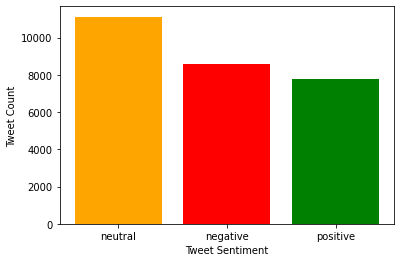

In [8]:
colors=['orange','red','green']
plt.bar(df.sentiment.unique(),df.sentiment.value_counts(), color=colors);
plt.xlabel('Tweet Sentiment');
plt.ylabel('Tweet Count');

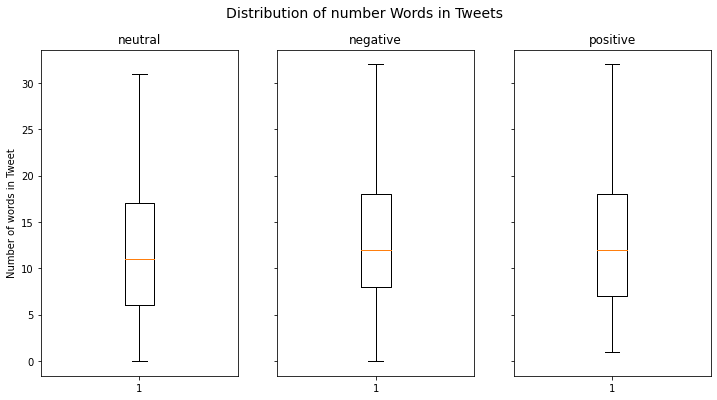

In [9]:
sent=df.sentiment.unique()
fig,ax= plt.subplots(1,3,figsize=(12,6),sharey=True)
for i in range(0,3):
    lengths = df_clean[df_clean['sentiment']==sent[i]]['text'].str.split().str.len()
    ax[i].boxplot(lengths)
    ax[i].set_title(sent[i])
ax[0].set_ylabel('Number of words in Tweet')
fig.suptitle("Distribution of number Words in Tweets", fontsize=14);

Text(0.5, 0.98, 'Common words in tweet text')

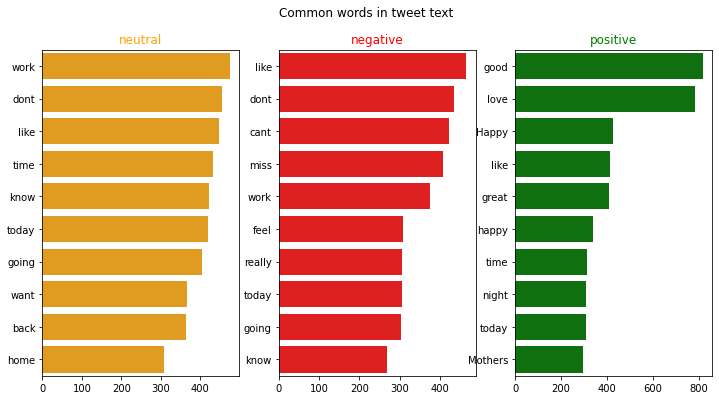

In [10]:
fig,ax=plt.subplots(1,3,figsize=(12,6))
for i in range(3):
    new=df_clean[df_clean['sentiment']==sent[i]]
    corpus_train=preprocess_news(new,n=3)
    counter=Counter(corpus_train)
    most=counter.most_common()
    x=[]
    y=[]
    for word,count in most[:10]:
        if (word not in stop) :
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x,ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i],color=colors[i])
fig.suptitle("Common words in tweet text")

## Preprocessing

For the labels, one-hot encoding performed significantly better than LabelEncoder. We also tokenize and covert to sequences. 

In [11]:
df_clean_selection = df_clean.sample(frac=1)
X = df_clean_selection.text.values
y = pd.get_dummies(df_clean_selection.sentiment)

In [12]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))
list_tokenized_train = tokenizer.texts_to_sequences(X)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=128)

# The model: DistilBert

We now turn our attention to pretrained embeddings. In this case we download and use DistilBert instead of training our own Embedding layer. DistilBert, a light version of BERT, google's game-changing NLP model, provides us with a tokenizer and an embedding matrix. BERT base uncased is trained on lower case English text and has around 110 million parameters (768 dimensions for embedding each word, and a vocab of 143,000 words). Distilbert has 60% of this, but maintains 97% performance against BERT. 

For the purposes of this example, we will leave that matrix rather than train it, as it's large and we would have unrealistic training times. 

In [13]:
tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-uncased")  ## change it to commit

# Save the loaded tokenizer locally
save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, add_special_tokens=True, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

In [14]:
X = fast_encode(df_clean_selection.text.astype(str), fast_tokenizer, maxlen=128)
X.shape

(27480, 128)

In [15]:
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [16]:
embedding_size = 128
input_ = Input(shape=(100,))

inp = Input(shape=(128, ))
#inp2= Input(shape=(1,))

embedding_matrix=transformer_layer.weights[0].numpy()

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],embeddings_initializer=Constant(embedding_matrix),trainable=False)(inp)
x = Bidirectional(LSTM(50, return_sequences=True))(x)
x = Bidirectional(LSTM(25, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu', kernel_regularizer='L1L2')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

model_DistilBert = Model(inputs=[inp], outputs=x)

In [17]:
model_DistilBert.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
model_DistilBert.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 768)          23440896  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 100)          327600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 50)           25200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550

In [19]:
model_DistilBert.fit(X,y,batch_size=32,epochs=10,validation_split=0.1)

Train on 24732 samples, validate on 2748 samples
Epoch 1/10
24732/24732 [==============================] - 357s 14ms/step - loss: 1.0516 - accuracy: 0.4328 - val_loss: 0.8719 - val_accuracy: 0.5466
Epoch 2/10
24732/24732 [==============================] - 355s 14ms/step - loss: 0.7733 - accuracy: 0.6604 - val_loss: 0.7032 - val_accuracy: 0.6776
Epoch 3/10
24732/24732 [==============================] - 355s 14ms/step - loss: 0.6668 - accuracy: 0.7299 - val_loss: 0.6407 - val_accuracy: 0.7354
Epoch 4/10
24732/24732 [==============================] - 355s 14ms/step - loss: 0.6310 - accuracy: 0.7461 - val_loss: 0.5925 - val_accuracy: 0.7478
Epoch 5/10
24732/24732 [==============================] - 347s 14ms/step - loss: 0.6070 - accuracy: 0.7565 - val_loss: 0.5817 - val_accuracy: 0.7529
Epoch 6/10
24732/24732 [==============================] - 343s 14ms/step - loss: 0.5922 - accuracy: 0.7635 - val_loss: 0.5817 - val_accuracy: 0.7584
Epoch 7/10
24732/24732 [==============================] -

# Inference

In [20]:
df_clean_final = df_clean.sample(frac=1)
X_train = fast_encode(df_clean_selection.text.astype(str), fast_tokenizer, maxlen=128)
y_train = y

In [21]:
Adam_name = adam(lr=0.001)
model_DistilBert.compile(loss='categorical_crossentropy',optimizer=Adam_name,metrics=['accuracy'])
history = model_DistilBert.fit(X_train,y_train,batch_size=32,epochs=10)

Epoch 1/10
27480/27480 [==============================] - 480s 17ms/step - loss: 0.5100 - accuracy: 0.7994
Epoch 2/10
27480/27480 [==============================] - 479s 17ms/step - loss: 0.4956 - accuracy: 0.8100
Epoch 3/10
27480/27480 [==============================] - 475s 17ms/step - loss: 0.4740 - accuracy: 0.8158
Epoch 4/10
27480/27480 [==============================] - 475s 17ms/step - loss: 0.4528 - accuracy: 0.8275
Epoch 5/10
27480/27480 [==============================] - 475s 17ms/step - loss: 0.4318 - accuracy: 0.8364
Epoch 6/10
27480/27480 [==============================] - 475s 17ms/step - loss: 0.4069 - accuracy: 0.8441
Epoch 7/10
27480/27480 [==============================] - 477s 17ms/step - loss: 0.3839 - accuracy: 0.8572
Epoch 8/10
27480/27480 [==============================] - 480s 17ms/step - loss: 0.3645 - accuracy: 0.8634
Epoch 9/10
27480/27480 [==============================] - 478s 17ms/step - loss: 0.3437 - accuracy: 0.8746
Epoch 10/10
27480/27480 [============

In [22]:
df_test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
df_test.dropna(inplace=True)
df_clean_test = clean(df_test)

X_test = fast_encode(df_clean_test.text.values.astype(str), fast_tokenizer, maxlen=128)
y_test = df_clean_test.sentiment

In [23]:
y_preds = model_DistilBert.predict(X_test)
y_predictions = pd.DataFrame(y_preds, columns=['negative','neutral','positive'])
y_predictions_final = y_predictions.idxmax(axis=1)
accuracy = accuracy_score(y_test,y_predictions_final)
print(f"The final model shows {accuracy:.2f} accuracy on the test set.")

The final model shows 0.74 accuracy on the test set.
